## Dropping New York and '0-17' age group
### Requires reconstructing dataframes

This is a copy of the similarly-named notebook.

In [3]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

## COVID By Age Analysis

In [7]:
# Define a global variable list for the age groupings to be used throughout this notebook.
age_groups_list = ['0_17', '18_49', '50_64', '65_plus']
short_age_groups_list = ['18_49', '50_64', '65_plus']

Let's import seroprevalence by age for each Round.

In [23]:
sp_df = pd.read_csv('../data/Nationwide_Commercial_Laboratory_Seroprevalence_Survey_December.csv')[
    ['Site','Date Range of Specimen Collection', 'Round', 'Catchment population', 
       'n [0-17 Years Prevalence]', 'n [18-49 Years Prevalence]',
       'n [50-64 Years Prevalence]', 'n [65+ Years Prevalence]',
       'Rate (%) [0-17 Years Prevalence]', 'Rate (%) [18-49 Years Prevalence]',
       'Rate (%) [50-64 Years Prevalence]', 'Rate (%) [65+ Years Prevalence]',
       'Rate (%) [Cumulative Prevalence]', 'Estimated cumulative infections count']]

# Recode 777 and 666 (samples were too small) to nan.
sp_df.replace(to_replace=777,value=np.nan,inplace=True)
sp_df.replace(to_replace=666,value=np.nan,inplace=True)

# Drop NY from the seroprevalence dataframe
sp_df = sp_df[sp_df['Site']!='NY']

sp_df.rename(columns={'Catchment population':'N_catchment',
                      'n [0-17 Years Prevalence]':'n_sample_0_17',
                      'n [18-49 Years Prevalence]':'n_sample_18_49',
                      'n [50-64 Years Prevalence]':'n_sample_50_64',
                      'n [65+ Years Prevalence]':'n_sample_65_plus',
                      'Rate (%) [0-17 Years Prevalence]':'pct_sample_0_17',
                      'Rate (%) [18-49 Years Prevalence]':'pct_sample_18_49',
                      'Rate (%) [50-64 Years Prevalence]':'pct_sample_50_64',
                      'Rate (%) [65+ Years Prevalence]':'pct_sample_65_plus',
                      'Estimated cumulative infections count':'n_est_infections_from_table'
                     },inplace=True)

In [24]:
print('Percent state/time period insufficient data\n')
for i in age_groups_list:
    print(f"Age group '{i}':  \t", 100-round(sp_df[f"pct_sample_{i}"].count()/len(sp_df)*100), f'%')

Percent state/time period insufficient data

Age group '0_17':  	 43 %
Age group '18_49':  	 6 %
Age group '50_64':  	 7 %
Age group '65_plus':  	 8 %


The seroprevalence DataFrame contains the total population for the state, but it doesn't provide the population by age group for each state. If we know the population by age for each state then we can calculate the total estimated infections by age and state from the infection rate by age that is provided in the seroprevalence DataFrame. We can use these estimates to calculate summary statistics such as the overall mean undercount rate with confidence intervals. 

We can obtain population by age and state from Census data and then merge the population data with the seroprevalence DataFrame to create a comprehensive DataFrame. Prior to merging the tables, we need to sum up the populations to create census age groupings that match the seroprevalence age groupings.

Source: https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-detail.html

### Loading in state census by age data

In [34]:
state_census = pd.read_csv('../data/sc-est2019-agesex-civ.csv')
state_census = state_census[state_census['SEX']==0][['STATE','NAME','AGE','POPEST2019_CIV']]

pop_grouped = state_census.groupby('STATE').agg(st_fips = ('STATE', 'max'),
                                                  st_name = ('NAME', 'max')).reset_index()

In [35]:
# Delete New York from the census count
state_census = state_census[state_census['NAME'] != 'New York']

In [36]:
del pop_grouped['STATE']
pop_grouped['pop_0_17'] = (state_census[state_census['AGE'].isin(range(0,18))].
                   groupby('STATE').sum()['POPEST2019_CIV'].reset_index())['POPEST2019_CIV']
pop_grouped['pop_18_49'] = (state_census[state_census['AGE'].isin(range(18,50))].
                   groupby('STATE')['POPEST2019_CIV'].sum().reset_index())['POPEST2019_CIV']
pop_grouped['pop_50_64'] = (state_census[state_census['AGE'].isin(range(50,65))].
                   groupby('STATE')['POPEST2019_CIV'].sum().reset_index())['POPEST2019_CIV']
pop_grouped['pop_65_plus'] = (state_census[state_census['AGE'].isin(range(65,100))].
                     groupby('STATE')['POPEST2019_CIV'].sum().reset_index())['POPEST2019_CIV']

We need to merge (join) the seroprevalence DataFrame with the census table DataFrame ('pop_grouped'), but the state field in the seroprevalence table ('Site') does not match the format of the state fields in the census table ('st+abbr' or 'st_name'). We are going to need to upload a table which contains state values which are common to both, and use that table to join the other two together. One of many tables that will work comes from the COVID Tracking Project. We will use that one here.

In [38]:
# Step 1. Load in the COVID Tracking Project dataset to facilitate merging seroprevalence and census DataFrames.
state_merge_df = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")[
                                ['state', 'fips']]

In [42]:
# Delete NY from COVID case counts
state_merge_df = state_merge_df[state_merge_df['state']!='NY']

In [43]:
# Step 2. Merge COVID Tracking Project DataFrame with census DataFrame by fips code which will populate census DataFrame with state two-letter abbreviation. 
pop_grouped = pop_grouped.merge(state_merge_df.groupby('state').max().reset_index(), 
                                           left_on = 'st_fips', right_on = 'fips')[
                ['st_name', 'state', 'fips', 'pop_0_17', 'pop_18_49',
                 'pop_50_64', 'pop_65_plus']]

In [44]:
# Step 3. Finally, merge census DataFrame from step 2 to populate seroprevalence DataFrame with census data by age and state.
sp_and_census_df = sp_df.merge(pop_grouped, left_on = 'Site', right_on = 'state')

In [45]:
def create_full_month_df(df, start_round, end_round):
    '''
    Create an abbreviated seroprevalence DataFrame consisting of rounds of the same month
    Parameters
    ----------
    df: pandas DataFrame
    start_round: number indicating first round to include
    end_round: number indicating last round to include
    Returns
    -------
    month_df: Pandas DataFrame
    '''
    month_df = df[(df['Round'] >= start_round) & (df['Round'] <= end_round)]
    month_df = month_df.groupby('Site').agg(
                        N_catchment = ('N_catchment', 'max'),
                        n_sample_0_17 = ('n_sample_0_17', 'sum'),
                        n_sample_18_49 = ('n_sample_18_49', 'sum'),
                        n_sample_50_64 = ('n_sample_50_64', 'sum'),
                        n_sample_65_plus = ('n_sample_65_plus', 'sum'),
                        pct_sample_0_17 = ('pct_sample_0_17', 'mean'),
                        pct_sample_18_49 = ('pct_sample_18_49', 'mean'),
                        pct_sample_50_64 = ('pct_sample_50_64', 'mean'),
                        pct_sample_65_plus = ('pct_sample_65_plus', 'mean'),
                        n_est_infections_from_table = ('n_est_infections_from_table', 'mean'),
                        pop_0_17 = ('pop_0_17', 'max'),
                        pop_18_49 = ('pop_18_49', 'max'),
                        pop_50_64 = ('pop_50_64', 'max'),
                        pop_65_plus = ('pop_65_plus', 'max'),                
                        )
    return month_df

In [46]:
def point_and_var_calcs(df):
    '''
    Calculates the estimated number of infections and the std error contribution for each stratum in a seroprevalence DataFrame
    Parameters 
    ----------
    df: pandas DataFrame
    Returns
    -------
    df: same Pandas DataFrame with new columns added
    '''
    
    for ages in age_groups_list:
        df[f'n_est_infections_{ages}'] = (df[f'pct_sample_{ages}'] * 
                                              df[f'pop_{ages}']) / 100
        df[f'stratum_std_err_contribution_{ages}'] = (df[f'pop_{ages}']**2 *
                                                     (1- df[f'n_sample_{ages}'] / 
                                                      df[f'pop_{ages}']) * 
                                                     (df[f'n_sample_{ages}'] / 
                                                      (df[f'n_sample_{ages}'] - 1)) * 
                                                     df[f'pct_sample_{ages}']/100 * 
                                                     (1 - df[f'pct_sample_{ages}']/100) / 
                                                     df[f'n_sample_{ages}'])
    return df


In [47]:
def missing_data_adj(df):
    '''
    Adjusts a seroprevalence DataFrame to account for missing data
    Parameters
    ----------
    df: pandas DataFrame
    Returns
    df: pandas DataFrame
    '''
    # Slight upward adjustment to counts to compensate for missing data
    df['pct_age_data_missing'] = (df['n_est_infections_from_table'] - 
                                       df['n_est_infections_0_17'] - 
                                       df['n_est_infections_18_49'] - 
                                       df['n_est_infections_50_64'] - 
                                       df['n_est_infections_65_plus'] ) / df['n_est_infections_from_table']

    for ages in age_groups_list:
        df[f'Est infections (from sp), {ages}'] = (df[f'n_est_infections_{ages}'] / 
                                    df[f'pop_{ages}'] / (1-df['pct_age_data_missing']))
    return df

In [48]:
def bar_chart_with_yerr(x_pos, means, std_devs, colors, suptitle, sub_title, tick_labels, sources, ylabel, chartname= 'misc'):
    fig, ax = plt.subplots(figsize = (10,7))
    ax.bar(x_pos, 
           means, 
           yerr=[i * critical_value for i in std_devs], 
           color=colors,
           align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel(ylabel)
    ax.set_title(sub_title)
    fig.suptitle(suptitle, size=15, y=0.95)
    plt.figtext(0.9, 0, sources, horizontalalignment='right')
    ax.yaxis.grid(True)
    plt.savefig(f'img/{chartname}.png');

In [49]:
august_df = create_full_month_df(sp_and_census_df, 0, 1)
november_df = create_full_month_df(sp_and_census_df, 7, 8)

In [50]:
august_df = point_and_var_calcs(august_df)
november_df = point_and_var_calcs(november_df)
sp_and_census_df = point_and_var_calcs(sp_and_census_df)

In [51]:
august_df = missing_data_adj(august_df)
november_df = missing_data_adj(november_df)

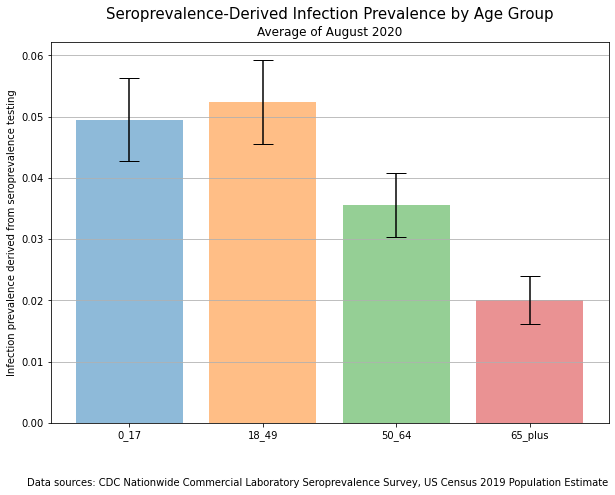

In [52]:
august_means, august_std = [], []
for ages in age_groups_list:
    august_means.append(august_df.sum()[f'n_est_infections_{ages}'] / august_df.sum()[f'pop_{ages}'])
    august_std.append(np.sqrt(august_df.sum()[f'stratum_std_err_contribution_{ages}']) / august_df.sum()[f'pop_{ages}'])

sup_title = '    Seroprevalence-Derived Infection Prevalence by Age Group'
sources_ = 'Data sources: CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate'
y_label = 'Infection prevalence derived from seroprevalence testing'
bar_chart_with_yerr(x_pos=range(len(age_groups_list)), means=august_means, std_devs=august_std, colors = ['C0', 'C1', 'C2', 'C3'],
                               suptitle=sup_title, sub_title='Average of August 2020', 
                               tick_labels=age_groups_list, sources=sources_, ylabel=y_label)

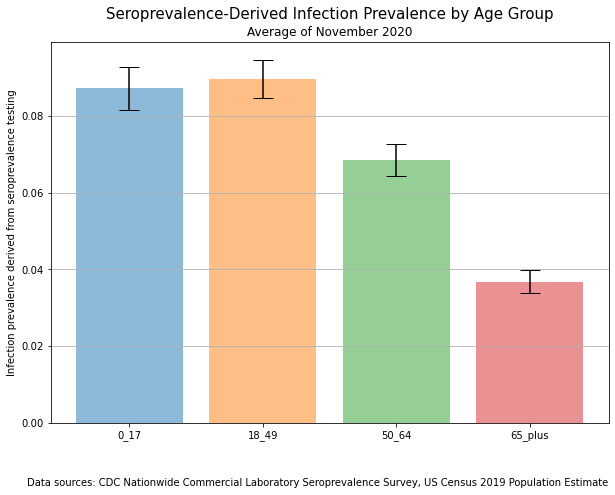

In [53]:
november_means, november_std = [], []
for ages in age_groups_list:
    november_means.append(november_df.sum()[f'n_est_infections_{ages}'] / november_df.sum()[f'pop_{ages}'])
    november_std.append(np.sqrt(november_df.sum()[f'stratum_std_err_contribution_{ages}']) / november_df.sum()[f'pop_{ages}'])

sup_title = '    Seroprevalence-Derived Infection Prevalence by Age Group'
sources_ = 'Data sources: CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate'
y_label = 'Infection prevalence derived from seroprevalence testing'
bar_chart_with_yerr(x_pos=range(len(age_groups_list)), means=november_means, std_devs=november_std, 
                               suptitle=sup_title, sub_title='Average of November 2020', colors = ['C0', 'C1', 'C2', 'C3'],
                               tick_labels=age_groups_list, sources=sources_, ylabel=y_label)

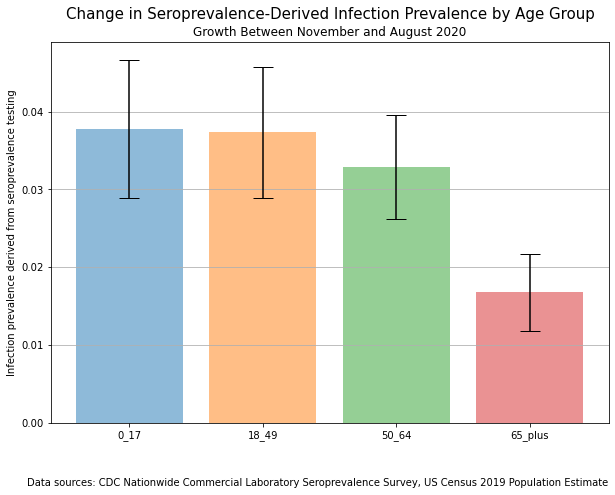

In [54]:
delta_means, delta_std = [], []
delta_means = [november_means[i] - august_means[i] for i in range(len(november_means))]
delta_std = [np.sqrt(november_std[i]**2 + august_std[i]**2) for i in range(len(november_means))]

sup_title = '    Change in Seroprevalence-Derived Infection Prevalence by Age Group'
sources_ = 'Data sources: CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate'
y_label = 'Infection prevalence derived from seroprevalence testing'
bar_chart_with_yerr(x_pos=range(len(age_groups_list)), means=delta_means, std_devs=delta_std, 
                               suptitle=sup_title, sub_title='Growth Between November and August 2020', 
                                colors = ['C0', 'C1', 'C2', 'C3'],
                               tick_labels=age_groups_list, sources=sources_, ylabel=y_label)

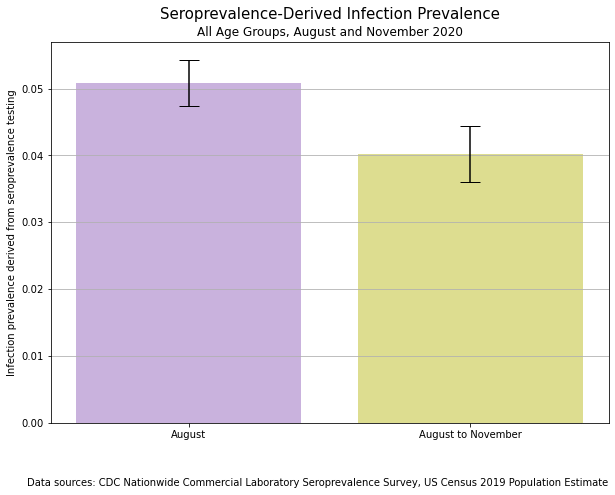

In [55]:
aug_nov_mean, aug_nov_std = [], []
aug_nov_mean.append(august_df.sum()[f'n_est_infections_from_table'] / august_df.sum()[f'N_catchment'])
aug_nov_std.append(np.sqrt(august_df.sum()[f'stratum_std_err_contribution_0_17'] + 
                 august_df.sum()[f'stratum_std_err_contribution_18_49'] +
                 august_df.sum()[f'stratum_std_err_contribution_50_64'] +
                 august_df.sum()[f'stratum_std_err_contribution_65_plus']) 
                 / august_df.sum()[f'N_catchment'])

aug_nov_mean.append(november_df.sum()[f'n_est_infections_from_table'] / november_df.sum()[f'N_catchment'] - 
                    august_df.sum()[f'n_est_infections_from_table'] / august_df.sum()[f'N_catchment'])
aug_nov_std.append(np.sqrt((np.sqrt(august_df.sum()[f'stratum_std_err_contribution_0_17'] + 
                 august_df.sum()[f'stratum_std_err_contribution_18_49'] +
                 august_df.sum()[f'stratum_std_err_contribution_50_64'] +
                 august_df.sum()[f'stratum_std_err_contribution_65_plus']) 
                 / august_df.sum()[f'N_catchment'])**2 +
                (np.sqrt(november_df.sum()[f'stratum_std_err_contribution_0_17'] + 
                 november_df.sum()[f'stratum_std_err_contribution_18_49'] +
                 november_df.sum()[f'stratum_std_err_contribution_50_64'] +
                 november_df.sum()[f'stratum_std_err_contribution_65_plus']) 
                 / november_df.sum()[f'N_catchment'])**2))

labels = ['August','August to November']
sup_title = '    Seroprevalence-Derived Infection Prevalence'
sources_ = 'Data sources: CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate'
y_label = 'Infection prevalence derived from seroprevalence testing'
bar_chart_with_yerr(x_pos=range(len(labels)), means=aug_nov_mean, std_devs=aug_nov_std, 
                               suptitle=sup_title, sub_title='All Age Groups, August and November 2020', 
                                 colors = ['C4', 'C8'],
                               tick_labels=labels, sources=sources_, ylabel=y_label)

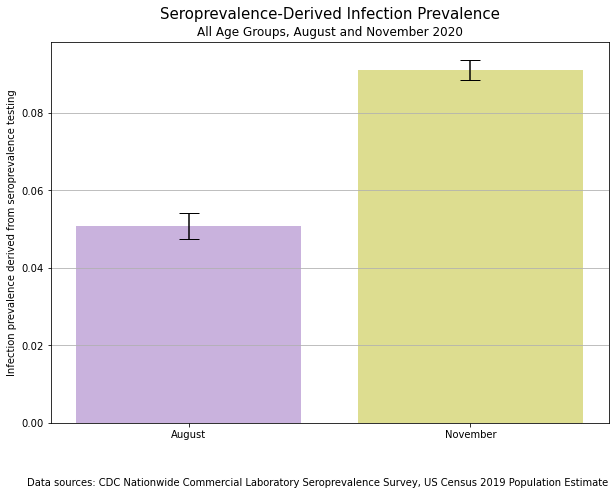

In [56]:
delta_aug_nov_mean, delta_aug_nov_std = [], []
delta_aug_nov_mean.append(august_df.sum()[f'n_est_infections_from_table'] / august_df.sum()[f'N_catchment'])
delta_aug_nov_std.append(np.sqrt(august_df.sum()[f'stratum_std_err_contribution_0_17'] + 
                 august_df.sum()[f'stratum_std_err_contribution_18_49'] +
                 august_df.sum()[f'stratum_std_err_contribution_50_64'] +
                 august_df.sum()[f'stratum_std_err_contribution_65_plus']) 
                 / august_df.sum()[f'N_catchment'])

delta_aug_nov_mean.append(november_df.sum()[f'n_est_infections_from_table'] / november_df.sum()[f'N_catchment'])
delta_aug_nov_std.append(np.sqrt(november_df.sum()[f'stratum_std_err_contribution_0_17'] + 
                 november_df.sum()[f'stratum_std_err_contribution_18_49'] +
                 november_df.sum()[f'stratum_std_err_contribution_50_64'] +
                 november_df.sum()[f'stratum_std_err_contribution_65_plus']) 
                 / november_df.sum()[f'N_catchment'])

labels = ['August','November']
sup_title = '    Seroprevalence-Derived Infection Prevalence'
sources_ = 'Data sources: CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate'
y_label = 'Infection prevalence derived from seroprevalence testing'
bar_chart_with_yerr(x_pos=range(len(labels)), means=delta_aug_nov_mean, std_devs=delta_aug_nov_std, 
                               suptitle=sup_title, sub_title='All Age Groups, August and November 2020', 
                                 colors = ['C4', 'C8'],
                               tick_labels=labels, sources=sources_, ylabel=y_label)

### Creating a usable date range
We need to convert the date range for each round to a usable format. The specimen collection windows differ slightly by state. Let's find the latest closing date for a given round to use as our marker. 

In [70]:
sp_and_census_df['date_range_close'] = pd.to_datetime(sp_and_census_df['Date Range of Specimen Collection'].
                                str[-12:].str.strip())
round_dates = (sp_and_census_df.groupby('Round').agg(
                                date_range_close = ('date_range_close', 'max'))
                                ) 
round_dates.head(2)

,date_range_close
Round,
1,2020-08-13
2,2020-08-27


### Aggregating by seroprevalence round
Let's now aggregate the data by seroprevalence rounds (i.e. batches). Once this is done we will adjust the counts upwards to compensate for missing data.

In [71]:
sp_by_round_df = sp_and_census_df.groupby('Round').agg(
                                    pop_0_17 = ('pop_0_17', 'sum'),
                                    pop_18_49 = ('pop_18_49', 'sum'),
                                    pop_50_64 = ('pop_50_64', 'sum'),
                                    pop_65_plus = ('pop_65_plus', 'sum'),
                                    n_est_infections_0_17 = ('n_est_infections_0_17', 'sum'),
                                    n_est_infections_18_49 = ('n_est_infections_18_49', 'sum'),
                                    n_est_infections_50_64 = ('n_est_infections_50_64', 'sum'),
                                    n_est_infections_65_plus = ('n_est_infections_65_plus', 'sum'),
                                    n_est_infections_from_table = ('n_est_infections_from_table', 'sum'),
                                    last_date_of_round = ('date_range_close', 'max')
                                ).reset_index()

In [72]:
# Slight upward adjustment to counts to compensate for missing data
sp_by_round_df['pct_age_data_missing'] = (sp_by_round_df['n_est_infections_from_table'] - 
                                       sp_by_round_df['n_est_infections_0_17'] - 
                                       sp_by_round_df['n_est_infections_18_49'] - 
                                       sp_by_round_df['n_est_infections_50_64'] - 
                                       sp_by_round_df['n_est_infections_65_plus'] ) / sp_by_round_df['n_est_infections_from_table']

for ages in age_groups_list:
    sp_by_round_df[f'Est infections (from sp), {ages}'] = (sp_by_round_df[f'n_est_infections_{ages}'] / 
                                    sp_by_round_df[f'pop_{ages}'] / (1-sp_by_round_df['pct_age_data_missing']))

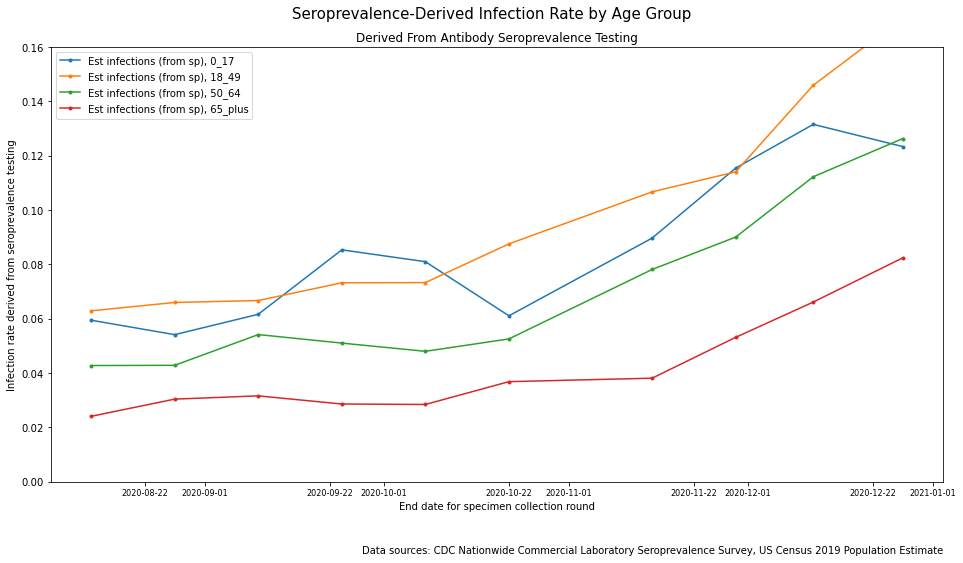

In [73]:
# Let's see what we have now.
fig, ax = plt.subplots(figsize = (16, 8))

for ages in age_groups_list:
    col_name = f'Est infections (from sp), {ages}'
    ax.plot(sp_by_round_df['last_date_of_round'],
            sp_by_round_df[col_name], 
            label = col_name,
            marker = '.')

ax.set_ylim(0,0.16)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.set_xlabel('End date for specimen collection round')
ax.set_ylabel('Infection rate derived from seroprevalence testing')
ax.set_title('Derived From Antibody Seroprevalence Testing')
ax.legend()
fig.suptitle(f'    Seroprevalence-Derived Infection Rate by Age Group', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate', horizontalalignment='right');
plt.savefig(f'img/seroprev_by_age_and_period.png')

### Loading and preparing case diagnosis data for comparison 

Now we need to do the same thing with the case data--calculate the case rate by age group. Let's start by summing up cumulative cases for each age group in the CDC data. We'll loop through the data 8 times--once for each of the specimen collection rounds. For each loop, we'll cut off the count at the date corresponding to that particular specimen collection round's cutoff date. Finally, we will transpose our table and then convert the age groups from the CDC data to match the age groups for the seroprevalence data.

We're also going to need to pull in estimated population from the US Census so we can calculate case diagnosis infection rates.

In [74]:
rows_ = 10000000 #dataset is large. Need to limit rows and/or columns to load.
CDC_case_df1 = pd.read_csv('../data/COVID-19_Case_Surveillance_Public_Use_Data_Feb_2021.csv', 
                          usecols=[0,5,6], encoding='latin-1', nrows=rows_, skiprows=1, header=None)
CDC_case_df2 = pd.read_csv('../data/COVID-19_Case_Surveillance_Public_Use_Data_Feb_2021.csv', 
                          usecols=[0,5,6], encoding='latin-1', nrows=rows_, skiprows=10000001, header=None)
# Source: https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf/data

In [75]:
CDC_case_df = pd.concat([CDC_case_df1, CDC_case_df2], ignore_index=True)

In [76]:
CDC_case_df.columns = ['cdc_case_earliest_dt ', 'sex', 'age_group']

In [77]:
CDC_case_df = CDC_case_df[CDC_case_df['age_group']!='Missing'] # less than 1% unknowns, so drop them.

In [78]:
# Create a new DataFrame with each cases by age_groups in rows and by round in columns. Transpose to orient properly.
age_group_df = pd.DataFrame(CDC_case_df['age_group'].unique(), columns=['age_group'])
round_ = 1

for date_ in sp_by_round_df['last_date_of_round']:
    curr_case_df = (CDC_case_df[pd.to_datetime(CDC_case_df['cdc_case_earliest_dt ']) < date_].
                    groupby('age_group').count()
                    )
    curr_case_df = curr_case_df.rename(columns={'sex': round_})[round_].reset_index()
    round_ +=1
    age_group_df = age_group_df.merge(curr_case_df, on='age_group')

age_group_df = age_group_df.T
age_group_df.columns = age_group_df.iloc[0]
age_group_df = age_group_df[1:]
age_group_df = age_group_df.reset_index().rename(columns={'index':'Round'})

In [79]:
# Aligning case count age groups with seroprevalence age groups.
age_group_df['cases_0_17'] = (age_group_df['0 - 9 Years'] + 
                              4/5 * age_group_df['10 - 19 Years'])
age_group_df['cases_18_49'] = (1/5 * age_group_df['10 - 19 Years'] + 
                               age_group_df['20 - 29 Years'] + 
                               age_group_df['30 - 39 Years'] +
                               age_group_df['40 - 49 Years'])
age_group_df['cases_50_64'] = (age_group_df['50 - 59 Years'] + 
                               1/2 * age_group_df['60 - 69 Years'])
age_group_df['cases_65_plus'] = (1/2* age_group_df['60 - 69 Years'] + 
                               age_group_df['70 - 79 Years'] + 
                               age_group_df['80+ Years'])

### Comparing antibody seroprevalence counts to antigen diagnostic case counts

In [80]:
# Merge the two distinct DataFrames
sp_and_case_df = sp_by_round_df.merge(age_group_df, on='Round')

In [81]:
sp_and_case_df

,Round,pop_0_17,pop_18_49,pop_50_64,pop_65_plus,n_est_infections_0_17,n_est_infections_18_49,n_est_infections_50_64,n_est_infections_65_plus,n_est_infections_from_table,...,30 - 39 Years,40 - 49 Years,50 - 59 Years,60 - 69 Years,70 - 79 Years,80+ Years,cases_0_17,cases_18_49,cases_50_64,cases_65_plus
0,1,66708947.0,124515864.0,56997541.0,49011023.0,3300449.820,6.517750e+06,2029217.870,983047.595,15416159.0,...,760961,702311,679983,472477,264154,243445,412407,2.38391e+06,916222,743838
1,2,66708947.0,124515864.0,56997541.0,49011023.0,2961570.961,6.737209e+06,2003214.246,1222407.695,15761065.0,...,838190,772384,746059,516985,289246,261311,481796,2.64738e+06,1.00455e+06,809050
2,3,66708947.0,124515864.0,56997541.0,49011023.0,3408906.573,6.885280e+06,2559857.629,1284915.026,17052717.0,...,906789,836111,806958,559241,313560,278987,556935,2.9057e+06,1.08658e+06,872168
3,4,66708947.0,124515864.0,56997541.0,49011023.0,4691070.480,7.512850e+06,2396893.798,1155700.230,19121889.0,...,975736,898618,867778,601576,337838,295399,625762,3.14775e+06,1.16857e+06,934025
4,5,66708947.0,124515864.0,56997541.0,49011023.0,4490448.434,7.585539e+06,2274348.575,1158936.462,18659163.0,...,1060944,976307,944000,657290,370626,316747,702462,3.43231e+06,1.27264e+06,1.01602e+06
5,6,66708947.0,124515864.0,56997541.0,49011023.0,3450971.550,9.231379e+06,2537853.038,1529565.899,19775212.0,...,1175804,1082116,1048970,733223,414017,345120,797406,3.80444e+06,1.41558e+06,1.12575e+06
6,7,66708947.0,124515864.0,56997541.0,49011023.0,4636101.180,1.029639e+07,3451331.692,1448245.066,25586437.0,...,1532625,1408706,1363964,958879,538193,425706,1.08905e+06,4.95748e+06,1.8434e+06,1.44334e+06
7,8,66708947.0,124515864.0,56997541.0,49011023.0,6281571.805,1.158442e+07,4186619.147,2125078.486,29636190.0,...,1810904,1663633,1613346,1138541,638322,493310,1.31018e+06,5.84091e+06,2.18262e+06,1.7009e+06
8,9,66708947.0,124515864.0,56997541.0,49011023.0,7015204.250,1.452739e+07,5114974.964,2591911.421,36577986.0,...,2145885,1966209,1905285,1346350,751490,573587,1.58064e+06,6.89542e+06,2.57846e+06,1.99825e+06
9,10,66708947.0,124515864.0,56997541.0,49011023.0,6659559.385,1.720243e+07,5826213.072,3269082.026,40714653.0,...,2483586,2276020,2210893,1565823,870939,656393,1.84706e+06,7.94978e+06,2.9938e+06,2.31024e+06


In [82]:
# Calculating the case undercount rates
for ages in age_groups_list:
    sp_and_case_df[f'Est infections (from cases), {ages}'] = (sp_and_case_df[f'cases_{ages}'] / sp_and_case_df[f'pop_{ages}'] /
                                           (1-pct_unknowns))
    sp_and_case_df[f'Undercount rate, {ages}'] = (sp_and_case_df[f'n_est_infections_{ages}'] / 
                                       sp_and_case_df[f'cases_{ages}'])


NameError: name 'pct_unknowns' is not defined

In [ ]:
# Chart case-derived estimate of infection rate by age group
fig, ax = plt.subplots(figsize = (16, 8))

for ages in age_groups_list:
    col_name = f'Est infections (from cases), {ages}'
    ax.plot(sp_and_case_df['last_date_of_round'],
            sp_and_case_df[col_name], 
            label = col_name,
            marker = '.')

ax.tick_params(axis='x', which='major', labelsize=8)
ax.set_ylim(0,0.16)
ax.set_xlabel('Specimen collection round number')
ax.set_ylabel('Infection rate derived from cases')
ax.set_title('Derived From Antigen Case Diagnostic Testing')
ax.legend()
fig.suptitle(f'  Case-Derived Infection Rate by Age Group', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC COVID-19 Case Surveillance Public Data', horizontalalignment='right')
plt.savefig(f'img/cases_by_age_and_period.png');

## Dropping New York and '0-17' age group
### Requires reconstructing dataframes

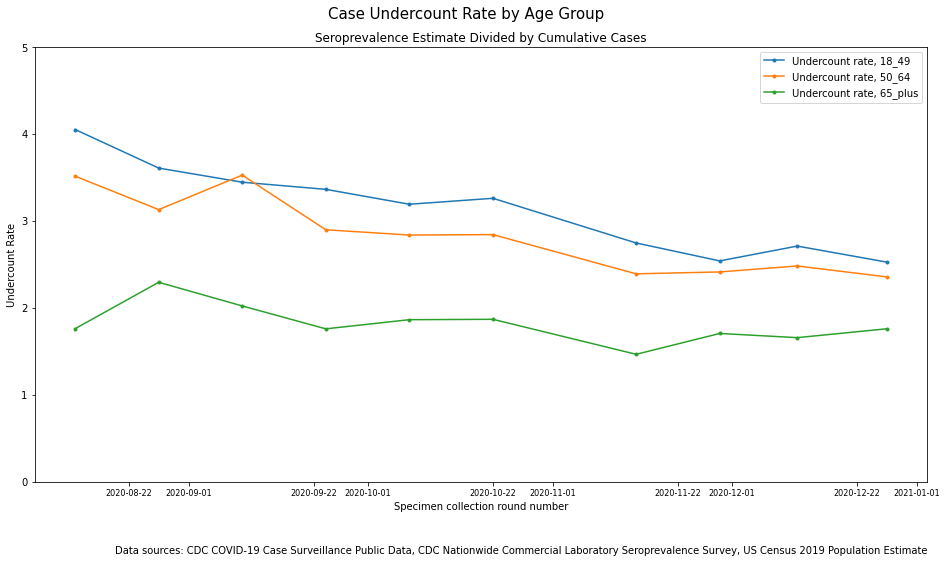

In [103]:
fig, ax = plt.subplots(figsize = (16, 8))

for ages in short_age_groups_list:
    col_name = f'Undercount rate, {ages}'
    ax.plot(sp_and_case_df['last_date_of_round'],
            sp_and_case_df[col_name], 
            label = col_name,
            marker = '.')

ax.tick_params(axis='x', which='major', labelsize=8)
ax.set_ylim(0,5)
ax.set_xlabel('Specimen collection round number')
ax.set_ylabel('Undercount Rate')
ax.set_title('Seroprevalence Estimate Divided by Cumulative Cases')
ax.legend()
fig.suptitle(f'Case Undercount Rate by Age Group', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC COVID-19 Case Surveillance Public Data, CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate', horizontalalignment='right')
plt.savefig(f'img/undercount_by_age_and_period.png');

Add in confidence intervals, statistical tests to describe how likely it is that the observed trends reflect actual trends. 

Try to come up with an estimate of how undercount rates by age have changed over time. Will need to estimate the undercount before August?

In [67]:
sp_and_case_df.columns

Index(['Round', 'pop_0_17', 'pop_18_49', 'pop_50_64', 'pop_65_plus',
       'n_est_infections_0_17', 'n_est_infections_18_49',
       'n_est_infections_50_64', 'n_est_infections_65_plus',
       'n_est_infections_from_table', 'last_date_of_round',
       'pct_age_data_missing', 'Est infections (from sp), 0_17',
       'Est infections (from sp), 18_49', 'Est infections (from sp), 50_64',
       'Est infections (from sp), 65_plus', '0 - 9 Years', '10 - 19 Years',
       '20 - 29 Years', '30 - 39 Years', '40 - 49 Years', '50 - 59 Years',
       '60 - 69 Years', '70 - 79 Years', '80+ Years', 'cases_0_17',
       'cases_18_49', 'cases_50_64', 'cases_65_plus',
       'Est infections (from cases), 0_17', 'Undercount rate, 0_17',
       'Est infections (from cases), 18_49', 'Undercount rate, 18_49',
       'Est infections (from cases), 50_64', 'Undercount rate, 50_64',
       'Est infections (from cases), 65_plus', 'Undercount rate, 65_plus'],
      dtype='object')

In [68]:
cols =['n_est_infections_0_17', 'n_est_infections_18_49', 'n_est_infections_50_64',
       'n_est_infections_65_plus', 'n_est_infections_from_table', 'cases_0_17', 'cases_18_49', 'cases_50_64',
       'cases_65_plus']

for ages in age_groups_list:
    col = f'n_est_infections_{ages}'
    baseline_new_name = col + '_baseline'
    sp_and_case_df[baseline_new_name] = (sp_and_case_df[col][0] + sp_and_case_df[col][1]) / 2
    change_new_name = col + '_change_from_base'
    sp_and_case_df[change_new_name] = sp_and_case_df[col] - sp_and_case_df[baseline_new_name]

for ages in age_groups_list:
    col = f'cases_{ages}'
    baseline_new_name = col + '_baseline'
    sp_and_case_df[baseline_new_name] = (sp_and_case_df[col][0] + sp_and_case_df[col][1]) / 2
    change_new_name = col + '_change_from_base'
    sp_and_case_df[change_new_name] = sp_and_case_df[col] - sp_and_case_df[baseline_new_name]

sp_and_case_df['Undercount rate (before August), 0_17'] = (sp_and_case_df['n_est_infections_0_17_baseline'] / 
                                       sp_and_case_df['cases_0_17_baseline'])
sp_and_case_df['Undercount rate (before August), 18_49'] = (sp_and_case_df['n_est_infections_18_49_baseline'] / 
                                        sp_and_case_df['cases_18_49_baseline'])
sp_and_case_df['Undercount rate (before August), 50_64'] = (sp_and_case_df['n_est_infections_50_64_baseline'] / 
                                        sp_and_case_df['cases_50_64_baseline'])
sp_and_case_df['Undercount rate (before August), 65_plus'] = (sp_and_case_df['n_est_infections_65_plus_baseline'] / 
                                          sp_and_case_df['cases_65_plus_baseline'])

sp_and_case_df['Undercount rate (from August), 0_17'] = (sp_and_case_df['n_est_infections_0_17_change_from_base'] / 
                                       sp_and_case_df['cases_0_17_change_from_base'])
sp_and_case_df['Undercount rate (from August), 18_49'] = (sp_and_case_df['n_est_infections_18_49_change_from_base'] / 
                                        sp_and_case_df['cases_18_49_change_from_base'])
sp_and_case_df['Undercount rate (from August), 50_64'] = (sp_and_case_df['n_est_infections_50_64_change_from_base'] / 
                                        sp_and_case_df['cases_50_64_change_from_base'])
sp_and_case_df['Undercount rate (from August), 65_plus'] = (sp_and_case_df['n_est_infections_65_plus_change_from_base'] / 
                                          sp_and_case_df['cases_65_plus_change_from_base'])

In [69]:
sp_and_case_df['cases_0_17_change_from_base']

0       -34694.6
1        34694.6
2         109834
3         178660
4         255360
5         350305
6         641949
7         863082
8    1.13353e+06
9    1.39996e+06
Name: cases_0_17_change_from_base, dtype: object

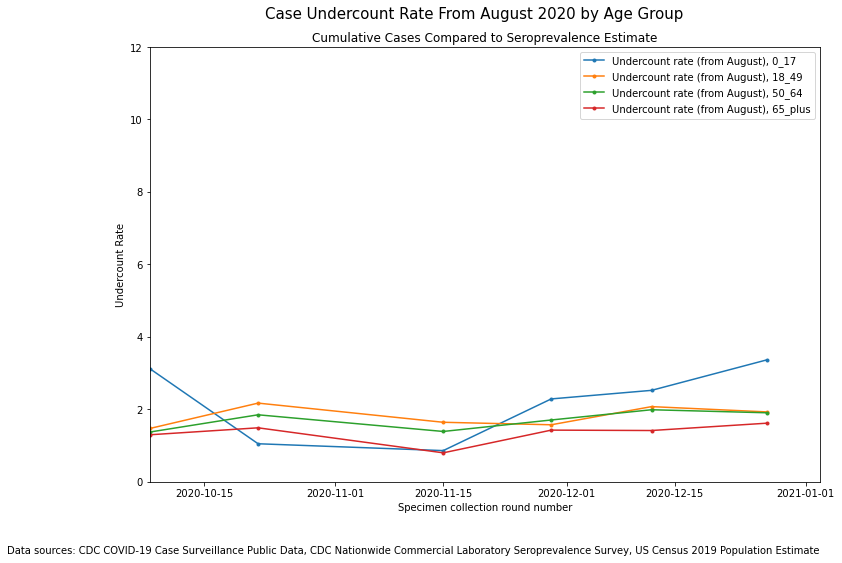

In [70]:
fig, ax = plt.subplots(figsize = (12, 8))

for ages in age_groups_list:
    col_name = f'Undercount rate (from August), {ages}'
    ax.plot(sp_and_case_df['last_date_of_round'],
            sp_and_case_df[col_name], 
            label = col_name,
            marker = '.')

ax.set_xlabel('Specimen collection round number')
ax.set_ylabel('Undercount Rate')
ax.set_title('Cumulative Cases Compared to Seroprevalence Estimate')
ax.set_xlim(left=sp_and_case_df['last_date_of_round'][4])
ax.set_ylim(0,12)
ax.legend()
fig.suptitle(f'Case Undercount Rate From August 2020 by Age Group', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC COVID-19 Case Surveillance Public Data, CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate', horizontalalignment='right');

In [71]:
summary_df = sp_and_case_df[sp_and_case_df['last_date_of_round']>'2020-10-01']

for col_name in ['Undercount rate (before August), 0_17', 'Undercount rate (before August), 18_49', 
                 'Undercount rate (before August), 50_64', 'Undercount rate (before August), 65_plus',
                 'Undercount rate (from August), 0_17', 'Undercount rate (from August), 18_49', 
                 'Undercount rate (from August), 50_64', 'Undercount rate (from August), 65_plus']:
    print(col_name[-7:], '  ', summary_df[col_name].mean())

), 0_17    10.090483762960147
, 18_49    3.817097974342378
, 50_64    3.3128020776010483
65_plus    2.0384877289847876
), 0_17    2.200827310313414
, 18_49    1.8105438360724901
, 50_64    1.7016617361757584
65_plus    1.341041910993552


## New section comparing August to difference between November and August

In [72]:
aug_case_rate_by_age, nov_minus_aug_case_rate_by_age = [], []
aug_ttl, nov_minus_aug_ttl, pop_ttl = 0, 0, 0
for ages in age_groups_list:
    aug_ttl += sp_and_case_df[f'cases_{ages}'].iloc[0]
    nov_minus_aug_ttl += sp_and_case_df[f'cases_{ages}'].iloc[6] - sp_and_case_df[f'cases_{ages}'].iloc[0]
    pop_ttl += sp_and_case_df[f'pop_{ages}'][0]
    
    aug_rate = sp_and_case_df[f'Est infections (from cases), {ages}'].iloc[:1].mean()
    nov_rate = sp_and_case_df[f'Est infections (from cases), {ages}'].iloc[6:7].mean()
    aug_case_rate_by_age.append(aug_rate)
    nov_minus_aug_case_rate_by_age.append(nov_rate - aug_rate)
case_rate_ttls = [aug_ttl / pop_ttl, nov_minus_aug_ttl / pop_ttl]

In [73]:
august_undercount_by_age = [august_means[i] / aug_case_rate_by_age[i] for i in range(len(august_means))]
august_undercount_by_age_std = [august_std[i] / august_means[i] * august_undercount_by_age[i]
                               for i in range(len(august_std))]

nov_minus_aug_undercount_by_age = [delta_means[i] / nov_minus_aug_case_rate_by_age[i] 
                                   for i in range(len(delta_means))]
nov_minus_aug_undercount_by_age_std = [delta_std[i] / delta_means[i] * nov_minus_aug_undercount_by_age[i] 
                                      for i in range(len(delta_means))]

august_delta_nov_undercount_ttl = [aug_nov_mean[i] / case_rate_ttls[i] for i in range(len(aug_nov_mean))]
august_delta_nov_undercount_std = [aug_nov_std[i] / aug_nov_mean[i] * august_delta_nov_undercount_ttl[i] 
                                   for i in range(len(aug_nov_mean))]


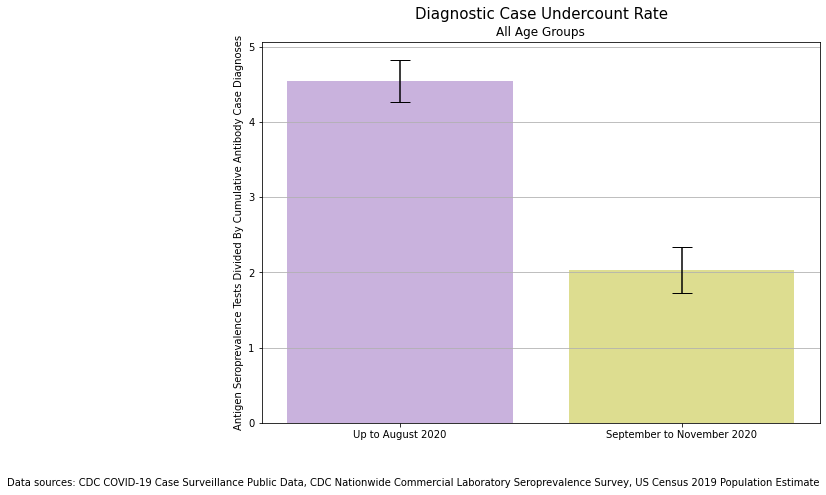

In [74]:

labels = ['Up to August 2020','September to November 2020']
sup_title = '    Diagnostic Case Undercount Rate'
sources_ = 'Data sources: CDC COVID-19 Case Surveillance Public Data, CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate'
y_label = 'Antigen Seroprevalence Tests Divided By Cumulative Antibody Case Diagnoses'
bar_chart_with_yerr(x_pos=range(len(labels)), means=august_delta_nov_undercount_ttl, std_devs=august_delta_nov_undercount_std, 
                               suptitle=sup_title, sub_title='All Age Groups', colors = ['C4', 'C8'],
                               tick_labels=labels, sources=sources_, ylabel=y_label, chartname='all_august_before_after')

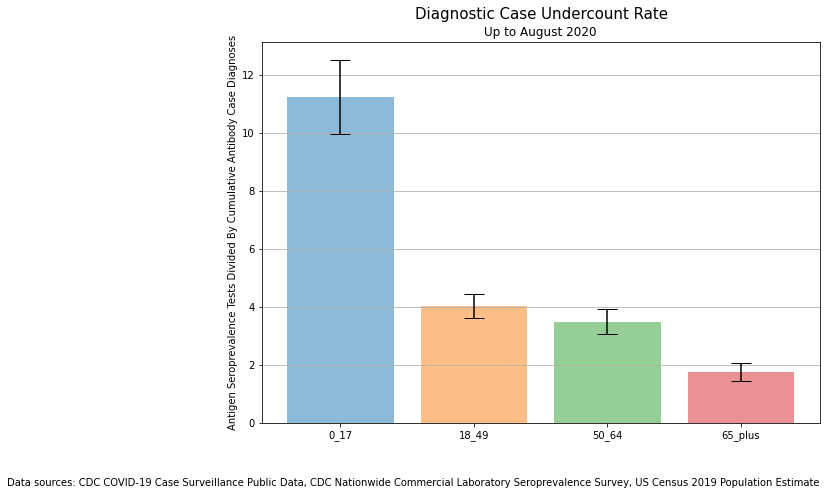

In [75]:
labels = age_groups_list
sup_title = '    Diagnostic Case Undercount Rate'
sources_ = 'Data sources: CDC COVID-19 Case Surveillance Public Data, CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate'
y_label = 'Antigen Seroprevalence Tests Divided By Cumulative Antibody Case Diagnoses'
bar_chart_with_yerr(x_pos=range(len(labels)), means=august_undercount_by_age, std_devs=august_undercount_by_age_std, 
                               suptitle=sup_title, sub_title='Up to August 2020', colors = ['C0', 'C1', 'C2', 'C3'],
                               tick_labels=labels, sources=sources_, ylabel=y_label)

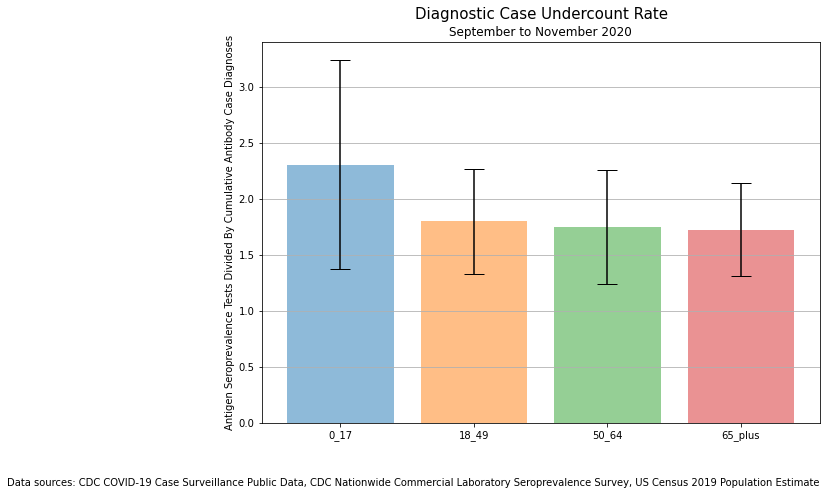

In [76]:
labels = age_groups_list
sup_title = '    Diagnostic Case Undercount Rate'
sources_ = 'Data sources: CDC COVID-19 Case Surveillance Public Data, CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate'
y_label = 'Antigen Seroprevalence Tests Divided By Cumulative Antibody Case Diagnoses'
bar_chart_with_yerr(x_pos=range(len(labels)), means=nov_minus_aug_undercount_by_age, std_devs=nov_minus_aug_undercount_by_age_std, 
                               suptitle=sup_title, sub_title='September to November 2020', colors = ['C0', 'C1', 'C2', 'C3'],
                               tick_labels=labels, sources=sources_, ylabel=y_label)